# 4. Confined Aquifer Test - Schroth
**This test is taken from examples presented in MLU tutorial.**

This test example was a pumping test conducted near San Francisco, US, and reported by Brian et al. (1997).
The system consists of a confined system of two aquifers separated by an aquitard layer. The upper aquifer layer is located from 46 to 49 m depth, followed by an aquitard layer from 49 to 52 m depth and the second aquifer at 52 to 55 m depth.

The lower aquifer is pumped by a well, named EW-712 that fully penetrates the formation. An observation well is placed 46 m away from the well, in the lower aquifer formation, and it is named MW-616. The last observation well is placed in the upper aquifer right on top of the pumping well. However, data was not available for this well. The radius of all wells was 0.05 m.

All wells before pumping had water levels around 20 m depth, which means that the system can be characterized as confined.

The time-drawdown data for the observation well MW-616 and pumping well EW-712 was obtained from MLU documentation (Duffield, 2007).

In this example, we are reproducing the results obtained by Yang (2020). We will use TTim to test two hypotheses: the first is that the lower aquifer is, by confinement, disconnected to the upper aquifer, and the second is there is enough leakage from the upper aquifer to consider a leaky aquifer relation between them.

A simplified cross-section of the model area can be seen below:

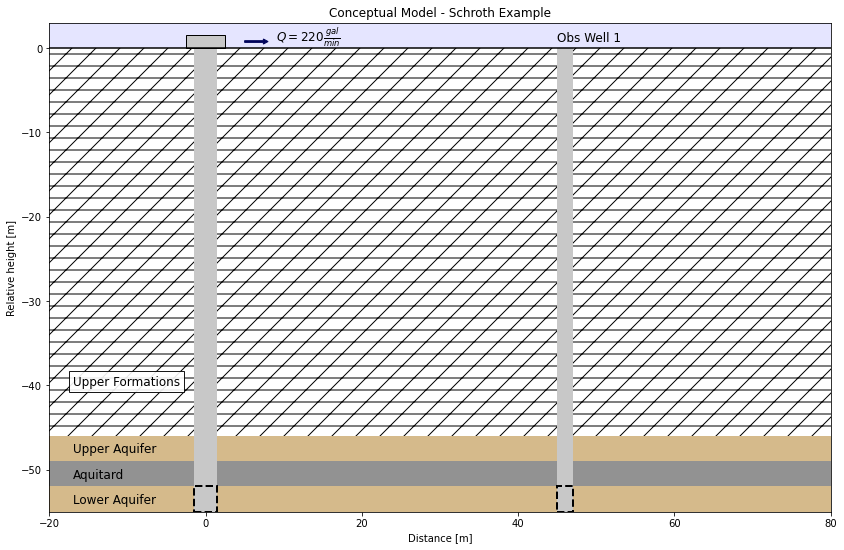

In [81]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1,1,1)
#sky
sky = plt.Rectangle((-20,0), width = 100, height = 3, fc = 'b', zorder=0, alpha=0.1)
ax.add_patch(sky)

#Aquifer 1:
ground = plt.Rectangle((-20,-55), width = 100, height = 3, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9)
ax.add_patch(ground)

#Aquifer 2:

ground = plt.Rectangle((-20,-49), width = 100, height = 3, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9)
ax.add_patch(ground)

#Confining bed:
confining_unit = plt.Rectangle((-20,-52), width = 100, height = 3, fc = np.array([100,100,100])/255, zorder=0, alpha=0.7)
ax.add_patch(confining_unit)

well = plt.Rectangle((-1.5,-55), width = 3, height = 55, fc = np.array([200,200,200])/255, zorder=1)
ax.add_patch(well)

#Wellhead
wellhead = plt.Rectangle((-2.5,0),width = 5, height = 1.5, fc = np.array([200,200,200])/255, zorder=2, ec='k')
ax.add_patch(wellhead)

#Screen for the well:
screen = plt.Rectangle((-1.5,-55), width = 3, height = 3, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x = 5,y = 0.75, dx = 3, dy = 0, color = "#00035b")
ax.add_patch(pumping_arrow)
ax.text(x = 9, y = 0.75, s = r'$ Q = 220 \frac{gal}{min}$', fontsize = 'large' )
#Piezometers
piez1 = plt.Rectangle((45,-55), width = 2, height = 55,fc = np.array([200,200,200])/255, zorder=1)
screen_piez_1 = plt.Rectangle((45,-55), width = 2, height = 3, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_1.set_linewidth(2)

ax.add_patch(piez1)

ax.add_patch(screen_piez_1)

#last line
line = plt.Line2D(xdata= [-20,100], ydata = [0,0], color = "k")
ax.add_line(line)
ax.text(x = 45, y = 0.75, s = 'Obs Well 1', fontsize = 'large' )

ax.text(x = -17, y = -40, s = 'Upper Formations', fontsize = 'large', bbox=dict(facecolor='w', alpha=0.9) )
ax.text(x = -17, y = -48, s = 'Upper Aquifer', fontsize = 'large' )
ax.text(x = -17, y = -51, s = 'Aquitard', fontsize = 'large' )
ax.text(x = -17, y = -54, s = 'Lower Aquifer', fontsize = 'large' )
# Complete the figure:

upper_formations = plt.Rectangle((-20,-46), width = 100, height = 46, fc = 'white', hatch = '-/', zorder=0, alpha=0.9)
ax.add_patch(upper_formations)

ax.set_xlim([-20,80])
ax.set_ylim([-55,3])
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Relative height [m]')
ax.set_title('Conceptual Model - Schroth Example');

## Step 1. Import Libraries

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ttim import *

## Step 2. Set basic parameters

In [83]:
Q = 82.08 #constant discharge in m^3/d
zt0 = -46 #top boundary of upper aquifer in m
zb0 = -49 #bottom boundary of upper aquifer in m
zt1 = -52 #top boundary of lower aquifer in m
zb1 = -55 #bottom boundary of lower aquifer in m
rw = 0.05 #well radius in m

## Step 3. Load data of the pumping and observation well

The preferred method of loading data into TTim is to use numpy arrays.

The data is in a text file where the first column is the time data in ***days*** and the second column is the drawdown in ***meters***

The observation well is referred to as ***Well 1*** and the pumping well as ***Well 3***.

For each piezometer, we will load the data as a numpy array. We further split the data into two different 1d arrays, one for time and another for drawdown.  Finally, we convert the time data from minutes to days

In [84]:
# Loading data for the pumping well
data1 = np.loadtxt('data/schroth_obs1.txt', skiprows = 1)
t1 = data1[:, 0]
h1 = data1[:, 1]
r1 = 0 #Pumping well is at distance 0 to pumping

# Loading data for the observation well
data2 = np.loadtxt('data/schroth_obs2.txt', skiprows = 1)
t2 = data2[:, 0]
h2 = data2[:, 1]
r2 = 46 #distance between observation well2 and pumping well

<a id='step_4'></a>
## Step 4. Create TTim model

We begin by considering the underlying aquifer as a single confined aquifer (overlying aquifer and aquitard are excluded).

In this example, we are using the ModelMaq model to conceptualize our aquifer. ModelMaq defines the aquifer system as a stacked vertical sequence of aquifers and leaky layers (aquifer-leaky layer, aquifer-leaky layer, etc). A thorough explanation of the ModelMaq and TTim one-layer modelling conceptualization is given in the notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk

In [85]:
ml_0 = ModelMaq(z=[zt1, zb1], kaq=10, Saq=1e-4, tmin=1e-4, tmax=1)
w_0 = Well(ml_0, xw=0, yw=0, rw=rw, tsandQ = [(0, Q), (1e+08, 0)])
ml_0.solve()

self.neq  1
solution complete


## Step 5. Calibration

The calibration workflow has been described in detail in the notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk)

In [86]:
ca_0 = Calibrate(ml_0)
ca_0.set_parameter(name='kaq0', initial=10)
ca_0.set_parameter(name='Saq0', initial=1e-4)
ca_0.series(name='well', x=r1, y=0, t=t1, h=h1, layer=0)
ca_0.series(name='obs_well', x=r2, y=0, t=t2, h=h2, layer=0)
ca_0.fit(report=True)

..................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 40
    # variables        = 2
    chi-square         = 111.249406
    reduced chi-square = 2.92761596
    Akaike info crit   = 44.9158052
    Bayesian info crit = 48.2935641
[[Variables]]
    kaq0:  1.03192659 +/- 0.10474707 (10.15%) (init = 10)
    Saq0:  0.04015974 +/- 0.02030471 (50.56%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.931


In [87]:
display(ca_0.parameters)
print('RMSE:', ca_0.rmse())

optimal       std   perc_std  pmin  pmax initial                 parray
kaq0  1.031927  0.104747  10.150632  -inf   inf      10   [1.0319265875171062]
Saq0   0.04016  0.020305  50.559856  -inf   inf  0.0001  [0.04015973783962348]

RMSE: 1.6677035580800887


Now let's plot the model with our observation data:

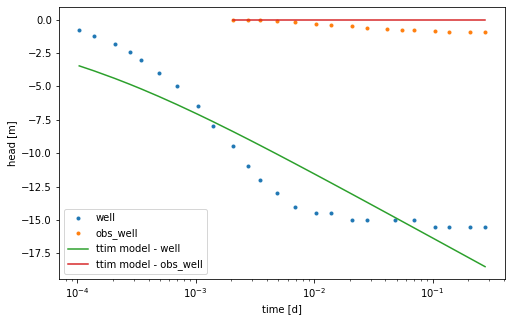

In [88]:
hm1_0 = ml_0.head(r1, 0, t1)
hm2_0 = ml_0.head(r2, 0, t2)
plt.figure(figsize = (8, 5))
plt.semilogx(t1, h1, '.', label='well')
plt.semilogx(t2, h2, '.', label='obs_well')
plt.semilogx(t1, hm1_0[-1], label='ttim model - well')
plt.semilogx(t2, hm2_0[-1], label='ttim model - obs_well')
plt.xlabel('time [d]')
plt.ylabel('head [m]')
plt.legend()


The figure shows a poor fit specially for the well. Probably well effects might be relevant in this case, so we will try to calibrate them next.

## Step 5.2. Model Calibration with skin resistance and wellbore storage

To improve the fit, we will try to calibrate the model adding wellbore storage and skin resistance to the pumping well.

For this, we create a new model and add two extra parameters to the ```Well``` object:

* The radius of the caisson ```rc```, which we use to simulate wellbore storage. In this case, we use a value in meters (float);
* The skin resistance ```res```, a float value with the unit in days.

In [89]:
ml_1 = ModelMaq(z=[zt1, zb1], kaq=10, Saq=1e-4, tmin=1e-4, tmax=1)
w_1 = Well(ml_1, xw=0, yw=0, rw=rw, rc=0, res=5, tsandQ = [(0, Q), (1e+08, 0)])
ml_1.solve()

self.neq  1
solution complete


Here we use the method ```.set_parameter_by_reference``` to calibrate the ```rc``` and ```res``` parameters in our well.

```.set_parameter_by_reference``` takes the following arguments:
* ```name```: a string of the parameter name
* ```parameter```: numpy-array with the parameter to be optimized. It should be specified as a reference, for example, in our case: ```w1.rc[0:]``` referencing to the parameter ```rc``` in object ```w1```.
* ```initial```: float with the initial guess for the parameter value.
* ```pmin``` and ```pmax```: floats with the minimum and maximum values allowed. If not specified, these will be ```-np.inf``` and ```np.inf```.

In [90]:
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name='kaq0', initial=10)
ca_1.set_parameter(name='Saq0', initial=1e-4)
ca_1.set_parameter_by_reference(name='rc', parameter=w_1.rc[:], initial=0.2)
ca_1.set_parameter_by_reference(name='res', parameter=w_1.res[:], initial=3)
ca_1.series(name='well', x=r1, y=0, t=t1, h=h1, layer=0)
ca_1.series(name='obs_well', x=r2, y=0, t=t2, h=h2, layer=0)
ca_1.fit(report=True)

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 500
    # data points      = 40
    # variables        = 4
    chi-square         = 13.6496505
    reduced chi-square = 0.37915696
    Akaike info crit   = -35.0066214
    Bayesian info crit = -28.2511036
[[Variables]]
    kaq0:  1.95212052 +/- 0.05268756 (2.70%) (init = 10)
    Saq0:  1.1462e-04 +/- 3.3123e-05 (28.90%) (init = 0.0001)
    rc:    0.00286298 +/- 0.02537531 (886.32%) (init = 0.2)
    re

In [91]:
display(ca_1.parameters)
print('RMSE:', ca_1.rmse())

optimal         std     perc_std  pmin  pmax initial  \
kaq0   1.952121    0.052688     2.698991  -inf   inf      10   
Saq0   0.000115    0.000033    28.899205  -inf   inf  0.0001   
rc     0.002863    0.025375   886.324928  -inf   inf     0.2   
res   32.495802  578.116053  1779.048442  -inf   inf       3   

                        parray  
kaq0      [1.9521205153188725]  
Saq0  [0.00011461682201140587]  
rc     [0.0028629803072082586]  
res        [32.49580165378371]

RMSE: 0.5841585939875874


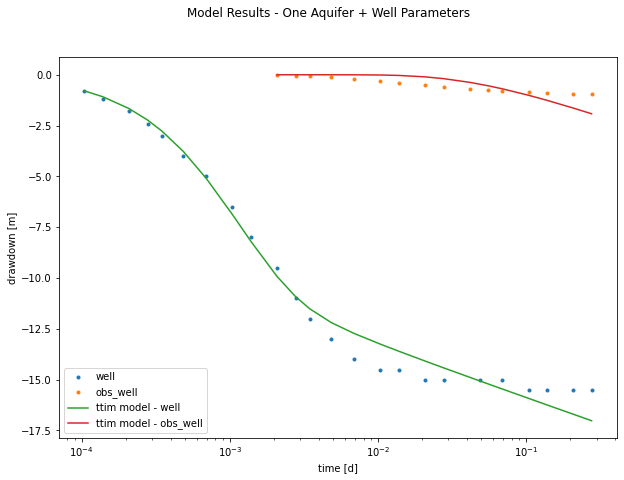

In [92]:
hm1_1 = ml_1.head(r1, 0, t1)
hm2_1 = ml_1.head(r2, 0, t2)
plt.figure(figsize = (10, 7))
plt.semilogx(t1, h1, '.', label='well')
plt.semilogx(t2, h2, '.', label='obs_well')
plt.semilogx(t1, hm1_1[-1], label='ttim model - well')
plt.semilogx(t2, hm2_1[-1], label='ttim model - obs_well')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.legend()
plt.suptitle('Model Results - One Aquifer + Well Parameters');


The model has improved significantly. However, we can visually see that the fit is not very good for late time data. Let us investigate if we can do better with a three-layer model such as the one defined in our conceptual model.

<a id='step_6'></a>
## Step 6. Create a two-aquifer conceptual model

Until so far, we have only considered horizontal flow in our TTim models. The assumption is sufficient in fully-penetrated wells in confined aquifers. However, it might not represent the situation so well in a more complex scenario, where the vertical flow is a relevant component of the groundwater flow. In TTim, this is done by assigning more layers to the model.

An advantage of TTim is the ability to create a model with more than one aquifer layer. We will explore this feature under the ```ModelMaq``` model as in [Step4](#step_4).

When we use ModelMaq, the leaky layers are located in between the aquifers. These leaky layers only have vertical flow and are characterized by the parameters resistance to vertical flow (```c```) and storage (```Sll```). The specific flux is computed as (Bakker, 2013):

$$q_n = \frac{h_n-h_{n-1}}{c_n}$$

where $q_n$ is the vertical flux from layer $n$ to layer $n-1$, $h_n$ is the head in layer $n$ and $c_n$ is the vertical resistance to flow. $c_n$ is computed as: $H_n/k_n$ where, $H_n$ is the leaky-layer thickness and $k_n$ the vertical hydraulic conductance. $c_n$ is the inverse of the parameter Leakance ($L_n = 1/c_n$), that is used in MODFLOW (Harbaugh, 2005) or analytical solutions of leaky-layers, such as in Hantush (1955).

Alternatively, we can also model the interface of two aquifers that are not separated by a leaky layer. In that case, the leaky layer is set to 0 m thickness, and the model calculates the resistance to vertical flow by a finite differences scheme (Bakker, 2013).

In the model construction, we have to set the parameters for each layer (which consists of an aquifer layer and an aquitard layer).

For our two-layer model, we have to set:

- The hydraulic conductivity: ```kaq```. It is a list/array with a float element for every aquifer, for example: ```[kaq0,kaq1]```.
- The top and bottom of each aquifer: ```z``` defined by a list/array ```[zt0,zb0,zt1,zb1,...]```, where the inputs are a sequence of top and bottoms of the aquifer layers. The aquitard layers are defined by the space between the aquifer layers. The top of the first aquitard is the bottom of the first aquifer, the bottom of the first aquitard is the top of the second aquifer, and so on. But they can also have 0 thickness. In case the parameter ```topboundary``` is set to ```semi```, where we assume we have semi-confined conditions, we have to add one more element to the beginning of the list, which is the top of the aquitard layer that is above of the first aquifer.
- The specific storage: ```Saq```. It is a list/array with a float element for every aquifer, for example: ```[Saq0, Saq1]```.
- The minimum time for which TTim solve the groundwater flow: ```tmin```, a float.
- And the maximum time: ```tmax```, float.
- ```topboundary``` is the parameter that sets whether the upper layer is a confined unit or a semi-confined unit. We can assign this parameter as:
    * ```'conf'```: This means that the upper layer is sealed from above in a confined condition;
    *```'semi'```: This means that the upper layer receives leakage from phreatic storage (```phreatictop = True```) or from a fixed head above the upper leaky-layer (```phreatictop = False```).
- TTim automatically assumes the ```topboundary``` is confined. In this case, we assume the ```topboundary``` is confined, so we do not need to set this parameter.
- The resistance to vertical flow: ```c``` of the aquitard layers, which is a list with length n-1 where n is the number of aquifer layers, setting the resistance of each aquitard layer. In the case of semi-confined conditions (```topboundary = " semi"```), we also add a first element representing the resistance of the aquitard above the first aquifer.
- The storage ```Sll``` of the aquitard layers: float/list/array with the specific storage values for each aquitard layer. In case a float is defined, the same storage is assumed for every layer. In case ```topboundary = semi``` and ```phreatictop = True```, the first element of ```Sll``` is the specific yield (see example [Unconfined - 1 - Vennebulten](unconfined1_vennebulten.ipynb)). 
- ```phreatictop```: Is a boolean (True/False). If ```True```, the first element in ```Saq``` is considered phreatic storage (Specific Yield), and it is not multiplied by the layer thickness. The default value is ```False``` in ```ModelMaq```. This parameter is normally ```True``` only in unconfined aquifers.

In [93]:
ml_2 = ModelMaq(kaq=[17.28, 2], z=[zt0, zb0, zt1, zb1], c=200, Saq=[1.2e-4, 1e-5],\
                 Sll=3e-5, topboundary='conf', tmin=1e-4, tmax=0.5)
w_2 = Well(ml_2, xw=0, yw=0, rw=rw, tsandQ = [(0, Q), (1e+08, 0)], layers=1)
ml_2.solve()

self.neq  1
solution complete


## Step 7. Calibrate Multi-Aquifer Model

Now we follow the procedures in step 5 again, but calibrating the parameters of both aquifers.

### Step 7.1. Calibrate model without wellstorage and skin resistance

Complementing the prior calibration, we add the hydraulic parameters of both layers 0 and 1 and the parameters of the aquitard layer in between. The procedure is the same as explained in Step 5.

In [106]:
ca_2 = Calibrate(ml_2)
ca_2.set_parameter(name= 'kaq0', initial=20, pmin=0, pmax = 200)
ca_2.set_parameter(name='kaq1', initial=1, pmin=0)
ca_2.set_parameter(name='Saq0', initial=1e-4, pmin=0)
ca_2.set_parameter(name='Saq1', initial=1e-5, pmin=0)
ca_2.set_parameter_by_reference(name='Sll', parameter=ml_2.aq.Sll[:],\
                                initial=1e-4, pmin=0)
ca_2.set_parameter(name='c1', initial=100, pmin=0)
ca_2.series(name='well', x=r1, y=0, t=t1, h=h1, layer=1)
ca_2.series(name='obs_well', x=r2, y=0, t=t2, h=h2, layer=1)
ca_2.fit(report=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [107]:
display(ca_2.parameters)
print('RMSE:',ca_2.rmse())

optimal            std      perc_std pmin pmax  initial  \
kaq0  198.862369  301357.634140  151540.80451    0  200       20   
kaq1    0.180469       0.268530     148.79573    0  inf        1   
Saq0    0.000936       0.267364  28567.022144    0  inf   0.0001   
Saq1    0.825022       1.266862    153.554939    0  inf  0.00001   
Sll     0.040398       4.798270   11877.45759    0  inf   0.0001   
c1      0.003581       0.009122    254.718788    0  inf      100   

                                          parray  
kaq0                        [198.86236919172697]  
kaq1                       [0.18046916945670866]  
Saq0                     [0.0009359185658521785]  
Saq1                        [0.8250220836732378]  
Sll   [0.04039812314065716, 0.04039812314065716]  
c1                       [0.0035811163576986438]

RMSE: 0.7913589821883213


The more complex model has improved the fit significantly from the first model. However, it showed worse RMSE, AIC and BIC values than the second model, with wellbore storage and skin resistance. We also have to note the unrealistic values found for the hydraulic conductivity of the upper layer and the storage parameters.

Next, we plot this model results.

Text(0.5, 0.98, 'Model Results - Two Aquifer Model')

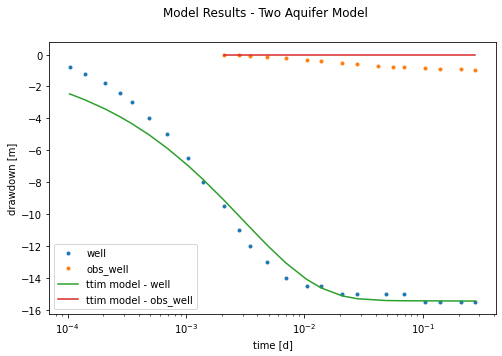

In [108]:
hm1_2 = ml_2.head(r1, 0, t1)
hm2_2 = ml_2.head(r2, 0, t2)
plt.figure(figsize = (8, 5))
plt.semilogx(t1, h1, '.', label='well')
plt.semilogx(t2, h2, '.', label='obs_well')
plt.semilogx(t1, hm1_2[-1], label='ttim model - well')
plt.semilogx(t2, hm2_2[-1], label='ttim model - obs_well')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.legend()
plt.suptitle('Model Results - Two Aquifer Model')


### Step 7.2. Calibrate the two-layer model with wellparameters

We will add the skinresistance and wellbore storage parameters to our well and resume calibration.

In [97]:
ml_3 = ModelMaq(kaq=[19, 2], z=[zt0, zb0, zt1, zb1], c=200, Saq=[4e-4, 1e-5],\
                 Sll=1e-4, topboundary='conf', tmin=1e-4, tmax=0.5)
w_3 = Well(ml_3, xw=0, yw=0, rw=rw, rc=0.2, res=0, tsandQ = [(0, Q), (1e+08, 0)], \
           layers=1)
ml_3.solve()

self.neq  1
solution complete


In [98]:
ca_3 = Calibrate(ml_3)
ca_3.set_parameter(name= 'kaq0', initial=20, pmin=0)
ca_3.set_parameter(name='kaq1', initial=1, pmin=0)
ca_3.set_parameter(name='Saq0', initial=1e-4, pmin=1e-7)
ca_3.set_parameter(name='Saq1', initial=1e-5, pmin=1e-7)
ca_3.set_parameter_by_reference(name='Sll', parameter=ml_3.aq.Sll[:],\
                                initial=1e-4, pmin=1e-7)
ca_3.set_parameter(name='c1', initial=100, pmin=0)
ca_3.set_parameter_by_reference(name='res', parameter=w_3.res[:], initial=0, pmin=0)
ca_3.set_parameter_by_reference(name='rc', parameter=w_3.rc[:], initial=0.2, pmin=0)
ca_3.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=1)
ca_3.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=1)
ca_3.fit(report=True)

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 543
    # data points      = 40
    # variables        = 8
    chi-square         = 1.28282624
    reduced chi-square = 0.04008832
    Akaike info crit   = -121.592553
    Bayesian info crit = -108.081517
[[Variables]]
    kaq0:  5.34928046 +/- 4.03563948 (75.44%) (init = 20)
    kaq1:  1.24351227 +/- 4.16240214 (334.73%) (init = 1)
    Saq0:  4.7262e-06 +/- 

In [99]:
display(ca_3.parameters)
print('RMSE:', ca_3.rmse())

optimal        std      perc_std pmin  pmax  initial  \
kaq0   5.34928   4.035639      75.44266    0   inf       20   
kaq1  1.243512   4.162402    334.729479    0   inf        1   
Saq0  0.000005   0.001078  22802.503015  0.0   inf   0.0001   
Saq1  0.000041   0.001006   2461.071155  0.0   inf  0.00001   
Sll   0.000004   0.000100   2756.471353  0.0   inf   0.0001   
c1    0.688224  18.241031   2650.449114    0   inf      100   
res   0.000001   0.000819  92429.061482    0   inf        0   
rc    0.055108   0.002836      5.146876    0   inf      0.2   

                                              parray  
kaq0                            [5.3492804615477505]  
kaq1                            [1.2435122686357878]  
Saq0                         [4.726225690920849e-06]  
Saq1                        [4.0870524957825616e-05]  
Sll   [3.620256154079904e-06, 3.620256154079904e-06]  
c1                              [0.6882241498810915]  
res                          [8.862192981684558e-07]  
rc                            [0.055108263395042156]

RMSE: 0.17908281848870644


Now we see a much better fit and AIC BIC values from the previous simulation. One thing to consider is the tiny storage values of the first aquifer and the aquitard. It might mean that it is troubling to fit all these parameters together. The small result of the skin resistance and its very high standard deviation might also mean it is irrelevant.

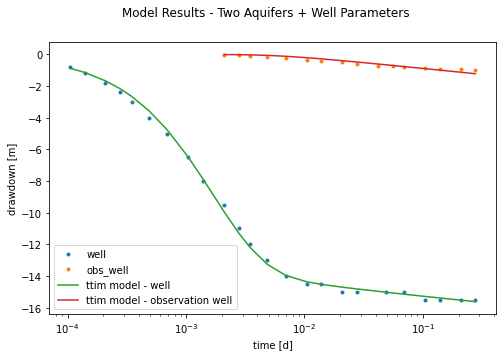

In [100]:
hm1_3 = ml_3.head(r1, 0, t1)
hm2_3 = ml_3.head(r2, 0, t2)
plt.figure(figsize = (8, 5))
plt.semilogx(t1, h1, '.', label='well')
plt.semilogx(t2, h2, '.', label='obs_well')
plt.semilogx(t1, hm1_3[-1], label='ttim model - well')
plt.semilogx(t2, hm2_3[-1], label='ttim model - observation well')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Results - Two Aquifers + Well Parameters')
plt.legend()


The plot showed the significant fit improvement with the new model.

### Step 7.3. Calibrate Model with some fixed parameters

In this new model, we will fix some of the parameters. Thus, we expect to have better confidence in estimating the others.

We will fix the hydraulic parameters of the first aquifer layer, the storage coefficient of the leaky layer and the skin resistance of the well. The fixed parameters were defined from the estimates of Brian et al. (1997).

In [101]:
ml_4 = ModelMaq(kaq=[17.28, 2], z=[zt0, zb0, zt1, zb1], c=200, Saq=[1.2e-4, 1e-5],\
                 Sll=3e-5, topboundary='conf', tmin=1e-4, tmax=0.5)
w_4 = Well(ml_4, xw=0, yw=0, rw=rw, rc=None, res=0, tsandQ = [(0, Q), (1e+08, 0)], \
           layers=1)
ml_4.solve()

self.neq  1
solution complete


In [102]:
ca_4 = Calibrate(ml_4)
ca_4.set_parameter(name='kaq1', initial=1, pmin=0)
ca_4.set_parameter(name='Saq1', initial=1e-5, pmin=0)
ca_4.set_parameter(name='c1', initial=100, pmin=0)
ca_4.set_parameter_by_reference(name='rc', parameter=w_4.rc[:], initial=0.2, pmin=0)
ca_4.series(name='well', x=r1, y=0, t=t1, h=h1, layer=1)
ca_4.series(name='obs_well', x=r2, y=0, t=t2, h=h2, layer=1)
ca_4.fit(report=True)

.......................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 40
    # variables        = 4
    chi-square         = 0.56418878
    reduced chi-square = 0.01567191
    Akaike info crit   = -162.449833
    Bayesian info crit = -155.694315
[[Variables]]
    kaq1:  1.93434307 +/- 0.01232289 (0.64%) (init = 1)
    Saq1:  1.3173e-05 +/- 2.3131e-06 (17.56%) (init = 1e-05)
    c1:    239.794659 +/- 20.5013561 (8.55%) (init = 100)
    rc:    0.05268693 +/- 4.0807e-04 (0.77%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq1, c1)   =  0.839
    C(Saq1, rc)   = -0.582
    C(kaq1, Saq1) = -0.503
    C(Saq1, c1)   = -0.214
    C(c1, rc)     = -0.111


In [103]:
display(ca_4.parameters)
print('RMSE:', ca_4.rmse())

optimal        std   perc_std pmin  pmax  initial  \
kaq1    1.934343   0.012323   0.637058    0   inf        1   
Saq1    0.000013   0.000002  17.559554    0   inf  0.00001   
c1    239.794659  20.501356   8.549547    0   inf      100   
rc      0.052687   0.000408    0.77451    0   inf      0.2   

                        parray  
kaq1      [1.9343430743882157]  
Saq1  [1.3172770564340297e-05]  
c1         [239.7946592515953]  
rc       [0.05268693339297337]

RMSE: 0.1187632921381165


The new estimates had much better confidence intervals when we used part of the parameters fixed. The RMSE, BIC and AIC indicators also showed better results.

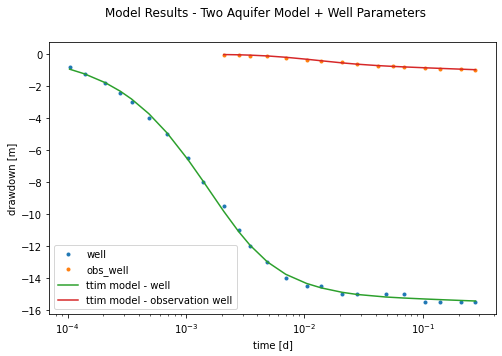

In [104]:
hm1_4 = ml_4.head(r1, 0, t1)
hm2_4 = ml_4.head(r2, 0, t2)
plt.figure(figsize = (8, 5))
plt.semilogx(t1, h1, '.', label='well')
plt.semilogx(t2, h2, '.', label='obs_well')
plt.semilogx(t1, hm1_4[-1], label='ttim model - well')
plt.semilogx(t2, hm2_4[-1], label='ttim model - observation well')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.suptitle('Model Results - Two Aquifer Model + Well Parameters')
plt.legend()


## Step 8. Comparison of Results

The results simulated with the two aquifer models are present below. Furthermore, Yang (2020) compared TTim results with the results obtained from MLU (Carlson & Randall, 2012) and the published results obtained by Brian et al. (1997). The authors of the original paper applied a finite-difference model of radial flow with a trial and error approach to find the optimal parameters.

In [105]:
t = pd.DataFrame(columns=['k0[m/d]','k1[m/d]','Ss0[1/m]','Ss1[1/m]','Sll[1/m]','c[d]',\
                         'res', 'rc'], \
                index=['MLU', 'Brian et al.','ttim','ttim-rc','ttim-fixed upper'])
t.loc['ttim-rc'] = ca_3.parameters['optimal'].values
t.iloc[2,0:6] = ca_2.parameters['optimal'].values
t.iloc[4,5] = ca_4.parameters['optimal'].values[2]
t.iloc[4,7] = ca_4.parameters['optimal'].values[3]
t.iloc[4,0] = 17.28
t.iloc[4,1] = ca_4.parameters['optimal'].values[0]
t.iloc[4,2] = 1.2e-4
t.iloc[4,3] = ca_4.parameters['optimal'].values[1]
t.iloc[4,4] = 3e-5
t.iloc[0, 0:6] = [17.424, 6.027e-05, 1.747, 6.473e-06, 3.997e-05, 216]
t.iloc[1, 0:6] = [17.28, 3.456, 1.2e-04, 1.5e-5, 3e-05, np.nan]
t['RMSE'] = [0.023452, np.nan, ca_2.rmse(), ca_3.rmse(), ca_4.rmse()]
t

k0[m/d]   k1[m/d]  Ss0[1/m]  Ss1[1/m]  Sll[1/m]  \
MLU                    17.424   0.00006     1.747  0.000006   0.00004   
Brian et al.            17.28     3.456   0.00012  0.000015   0.00003   
ttim              6727.138854  0.052148  0.887835  3.480486  0.086862   
ttim-rc               5.34928  1.243512  0.000005  0.000041  0.000004   
ttim-fixed upper        17.28  1.934343   0.00012  0.000013   0.00003   

                        c[d]       res        rc      RMSE  
MLU                      216       NaN       NaN  0.023452  
Brian et al.             NaN       NaN       NaN       NaN  
ttim                0.000653       NaN       NaN  0.720345  
ttim-rc             0.688224  0.000001  0.055108  0.179083  
ttim-fixed upper  239.794659       NaN  0.052687  0.118763

The first TTim model showed unrealistic results. The second model, although improving the fit, had wide standard deviations (and confidence intervals). That indicates that this solution, with more parameters, in multi-aquifer configuration, is non-unique. 

 When we kept some of the data fixed with the values from Brian et al., we improved the fit and the confidence interval of the estimates of the model.

MLU results have very low RMSE. However, the specific storage of the upper aquifer (Ss0) is probably too high.

### Step 8.1. Comparison of estimates and model error


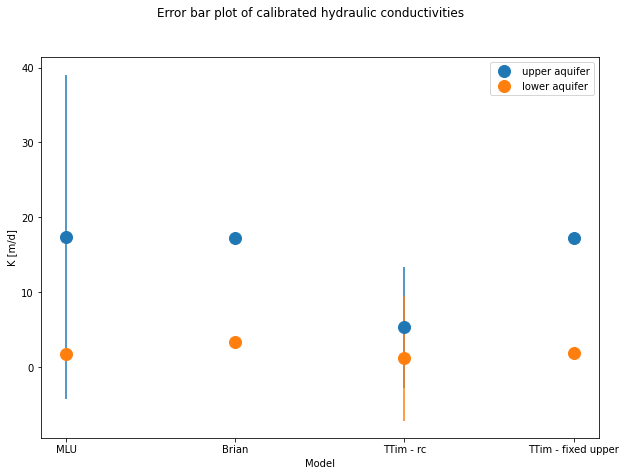

In [111]:
# Preparing the DataFrame:
t1 = pd.DataFrame(columns=['kaq - opt -l1', 'kaq - 95% -l1','kaq - opt -l2', 'kaq - 95% -l2' ], index = ['MLU','Brian','TTim - rc', 'TTim - fixed upper']) 
simulation = ['MLU','Brian','TTim - rc', 'TTim - fixed upper']
t1.loc['MLU'] = [17.424,  124.160*1e-2*17.424,1.747,4.521*1e-2*1.747]
t1.loc['Brian'] = [17.28, np.nan, 3.456, np.nan]
t1.loc['TTim - fixed upper'] = [17.28,np.nan,ca_4.parameters.loc['kaq1','optimal'],2*ca_4.parameters.loc['kaq1','std']]
t1.loc['TTim - rc'] = [ca_3.parameters.loc['kaq0','optimal'],2*ca_3.parameters.loc['kaq0','std'],ca_3.parameters.loc['kaq1','optimal'],2*ca_3.parameters.loc['kaq1','std']]

# Plotting

plt.figure(figsize = (10,7))

plt.errorbar(x = t1.index, y = t1['kaq - opt -l1'], yerr = [t1['kaq - 95% -l1'], t1['kaq - 95% -l1']],
    marker='o', linestyle='', markersize=12, label = 'upper aquifer')
plt.errorbar(x = t1.index, y = t1['kaq - opt -l2'], yerr = [t1['kaq - 95% -l2'], t1['kaq - 95% -l2']],
    marker='o', linestyle='', markersize=12, label = 'lower aquifer')

plt.legend()
plt.suptitle("Error bar plot of calibrated hydraulic conductivities")
plt.ylabel('K [m/d]')
#plt.ylim([278,289])
plt.xlabel('Model');

The MLU model has a larger confidence interval for the first aquifer layer, while TTim got lower values for the generic model (TTim - rc) and a relatively small range. The model with some fixed values has a small confidence interval. Confidence intervals were not reported in Brian et al. (1997).

## References

* Bakker, M. Semi-analytic modeling of transient multi-layer flow with TTim. Hydrogeol J 21, 935–943 (2013). https://doi.org/10.1007/s10040-013-0975-2
* Brian, Schroth, T., N., Narasimhan, 1997. Application of a numerical model in the interpretation of a leaky aquifer test. Ground Water .
* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.

#### Next Notebook: [Confined 5 - Nevada](confined5_nevada.ipynb)